In [1]:
import warnings
warnings.filterwarnings('ignore')
import spacy
import re
nlp = spacy.load('en_core_web_sm')

In [2]:
L = list(nlp.vocab.strings)
len(L)

84780

In [3]:
L[55000]

'interprovincial'

In [4]:
# L

In [5]:
import numpy as np
import pandas as pd
from collections import Counter
import re

In [6]:
df = pd.read_csv('../DataSets/reviews.csv')

In [7]:
df.head()

,rating,review
0,negative,terrible place to work for i just heard a stor...
1,negative,"hours , minutes total time for an extremely s..."
2,negative,my less than stellar review is for service . w...
3,negative,i m granting one star because there s no way t...
4,negative,the food here is mediocre at best . i went aft...


In [8]:
vocab = {}

In [9]:
def initializeVocabulary():
    unkToken = '<UNK>'
    vocab['t_2_i'] = {}
    vocab['i_2_t'] = {}
    vocab['unkToken'] = unkToken
    idx = addToken(unkToken)
    vocab['unkTokenIdx'] = idx

In [10]:
def addToken(token):
    if token in vocab['t_2_i']:
        idx = vocab['t_2_i'][token]
    else:
        idx = len(vocab['t_2_i'])
        vocab['t_2_i'][token] = idx
        vocab['i_2_t'][idx] = token
    return idx

In [11]:
def addManyTokens(tokens):
    idxes = [addToken(token) for token in tokens]
    return idxes

In [12]:
def lookUpToken(token):
    if vocab['unkTokenIdx']>=0:
        return vocab['t_2_i'].get(token,vocab['unkTokenIdx'])

In [13]:
def lookUpIndex(idx):
    if idx not in vocab['i_2_t']:
        raise KeyError('Index %d is not present in the vocabulary!!' % idx)
    else:
        return vocab['i_2_t'][idx]

In [14]:
# initializeVocabulary()
# vocab

In [15]:
# addToken('Shammi')
# addManyTokens(['Arosh', 'Shatin'])
# vocab

In [16]:
# lookUpToken('Arosh')

In [17]:
# lookUpIndex(1)

In [18]:
def vocabularyFromDataFrame(df, cutoff = 25):
    initializeVocabulary()
    wordCounts = Counter()
    for r in df.review:
        for word in re.split('\W+', r):
            wordCounts[word] += 1
    for word, count in wordCounts.items():
        if count > cutoff:
            addToken(word)

In [19]:
vocabularyFromDataFrame(df)

In [20]:
# vocab
print(len(vocab['i_2_t']))
print(len(vocab['t_2_i']))

8946
8946


In [21]:
def vocabularyFromCorpus(Corpus,cutoff=25):
    initializeVocabulary()
    wordCounts = Counter()
    for doc in Corpus:
        for word in re.split('\W+',doc):
            wordCounts[word] += 1
    for word,count in wordCounts.items():
        if count > cutoff:
            addToken(word)

In [22]:
Corpus = np.asarray(df['review'])
vocabularyFromCorpus(Corpus)

In [23]:
print(len(vocab['i_2_t']))
print(len(vocab['t_2_i']))

8946
8946


In [24]:
def oneHotVector(token, N):
    oneHot = np.zeros((N, 1))
    oneHot[lookUpToken(token)] = 1
    return oneHot

In [25]:
# lookUpIndex(1)

In [26]:
N = len(vocab['i_2_t'])
oneHotVector('terrible', N)

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(8946, 1))

## Compute Feature Vector for one review 

In [27]:
def computeFeatures(doc, N):
    isFirst = True
    for token in doc:
        oneHot = oneHotVector(token, N)
        if isFirst:
            xF = oneHot
            isFirst = False
        else:
            xF = np.hstack((xF, oneHot))
    return np.mean(xF, axis=1)[:,np.newaxis]

In [28]:
%timeit fV = computeFeatures(Corpus[1],len(vocab['t_2_i']))
# fV

214 ms ± 44.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
def computeFeatures_fast(doc,N):
    fv = np.zeros(N)
    numTokens = 0
    for token in doc:
        fv[lookUpToken(token)] += 1
        numTokens += 1
    return fv/numTokens

In [30]:
%timeit fV = computeFeatures_fast(Corpus[1],len(vocab['t_2_i']))
# fV

72.6 μs ± 19.7 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
# def corpusToFeatureMatrix(Corpus, N):
#     isFirst = True
#     for doc in Corpus:
#         fV = computeFeatures(doc, N)
#         if isFirst:
#             fM = fV
#             isFirst = False
#         else:
#             fM = np.hstack((fM, fV))
#     return fM.T

In [32]:
def corpusToFeatureMatrix_fast(Corpus,N):
    fM = np.zeros((N,len(Corpus)))
    i = 0
    for doc in Corpus:
        fM[:,i] = computeFeatures_fast(doc,N)
        i+=1
    return fM.T

## Let's classify now

In [33]:
df = pd.read_csv('../DataSets/reviews.csv')
X = np.asarray(df['review'])
y = np.asarray(df['rating'])

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,shuffle=True)

In [36]:
vocabularyFromCorpus(Xtrain)

In [37]:
# N = len(vocab['t_2_i'])
# Xtrain_fM = corpusToFeatureMatrix(Xtrain,N)
# Xtest_fM = corpusToFeatureMatrix(Xtest,N)

In [38]:
N = len(vocab['t_2_i'])
Xtrain_fM = corpusToFeatureMatrix_fast(Xtrain,N)
Xtest_fM = corpusToFeatureMatrix_fast(Xtest,N)

In [39]:
Xtrain_fM.shape

(39200, 7358)

In [40]:
Xtest_fM.shape

(16800, 7358)

In [41]:
from sklearn.linear_model import LogisticRegression as clf  #66.86%
# from sklearn.naive_bayes import GaussianNB as clf  #59.01%
# from sklearn.ensemble import RandomForestClassifier as clf  #66.14%
# from sklearn.svm import SVC as clf #66.79%(took a huge amount of time)

from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [42]:
Model = clf().fit(Xtrain_fM, ytrain)

In [43]:
y_pred = Model.predict(Xtest_fM)

Text(110.44999999999997, 0.5, 'Predicted Label')

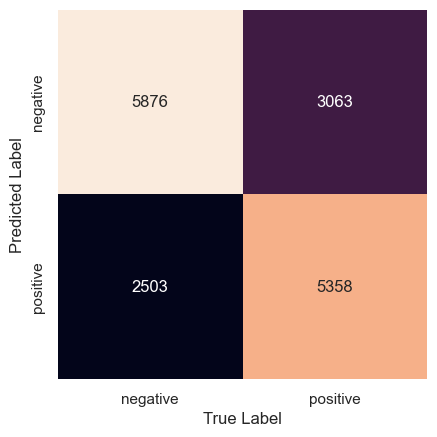

In [44]:
mat = confusion_matrix(ytest,y_pred)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
           xticklabels=np.unique(y),yticklabels=np.unique(y))
plt.xlabel("True Label")
plt.ylabel("Predicted Label")

In [45]:
Model.score(Xtest_fM, ytest)

0.6686904761904762